Se desarolla las ecuaciones en tiempo conforme, de esta manera se utiliza el estandar en el ambito y se simplifican las ecuaciones de onda al passar por el radio de Hubble, las ecuaciones son

$$a(\tau) = -\frac{1}{H_{\text{inf}} \tau}$$
$$H(\tau) = H_{\text{inf}} = \text{constante}$$

En este contexto se puede desarrollar $H_{inf} = 1$ debido a que se toman unidades naturales, asimismo se definene los los tiempos conformes iniciales y finales para el desarrollo de la simalución

In [1]:
#Se desarrollan las constantes utilizadas a lo largo del codigo y se ponen los paquetes necesarios
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display, HTML
import tempfile
import os
import pyvista as pv
from tqdm import tqdm
from scipy import stats

H_inf  = 1
sigma = 0.75 #dValor sensible, no mover mucho
mass = 0.01
tau_init = -20.0
tau_fin = -0.1
tau_array = np.arange(tau_init, tau_fin, 0.1)
delta_tau = tau_array[1] - tau_array[0]

In [2]:
#Se parte definiendo las funciones que serán utiles para el ruido cuantico
#Se deja en claro que se utilizará el tiempo conforme y el espacio conforme por facilidad y utilidad en el tema
def cosmological_a(tau):
    return -1/(H_inf* tau)

def k_sigma_func(tau):
    return sigma*cosmological_a(tau)*H_inf


In [3]:
def window_derivative_de_sitter(k, tau, sigma, delta=0.6): #Recomendación: No manipular mucho el delta
    k_sigma_val = k_sigma_func(tau)
    dk_sigma_dtau = sigma / (tau**2)
    x = k / k_sigma_val
    z = (1 - x) / delta
    
    # Se desarrolla esta sección para evitar el overflow que realiza la funcion sech(z)^2
    if hasattr(z, '__len__'):
        # Para arrays
        result = np.zeros_like(k)
        
        # Máscara para valores de z que no causan overflow
        valid_mask = np.abs(z) <= 20
        
        if np.any(valid_mask):
            z_valid = z[valid_mask]
            # Calcular sech(z)^2 de manera estable
            exp_z = np.exp(z_valid)
            exp_neg_z = np.exp(-z_valid)
            cosh_z = (exp_z + exp_neg_z) / 2
            sech2 = 1.0 / (cosh_z * cosh_z)
            
            result[valid_mask] = (k[valid_mask] / (2 * delta * k_sigma_val**2)) * dk_sigma_dtau * sech2
        
        # Para k=0, la derivada debe ser cero
        result[k == 0] = 0.0
        
    else:
        # Para escalares
        if k == 0:
            return 0.0
            
        if np.abs(z) > 20:
            return 0.0
        
        # Calcular sech²(z) de manera estable
        exp_z = np.exp(z)
        exp_neg_z = np.exp(-z)
        cosh_z = (exp_z + exp_neg_z) / 2
        sech2 = 1.0 / (cosh_z * cosh_z)
        
        result = (k / (2 * delta * k_sigma_val**2)) * dk_sigma_dtau * sech2
    
    return result

En este caso se utilizan los operadores de creación y aniquilación como variables gaussianas complejas de forma que $Z$ sea la variable gaussiana compleja que compone de $X$ y $Y$ de forma $Z = \frac{X + iY}{\sqrt{2}}$ de esta forma se asegura que tengan varianza 1 y valor de expectación 0 para que cumpla el comportamiento cuantico que buscamos

In [4]:
def creat_gaussian_oper():
    X = np.random.normal()
    Y = np.random.normal()
    return (X + 1j * Y)/np.sqrt(2)

Ahora se definen los modos de Fourier del Compo Infalton y su momento asociado de forma que sirvan para un vació de Bunch Davis

In [5]:
def phi_k_dS(k, tau):
    return (1/cosmological_a(tau)*np.sqrt(2*k))*(1 + 1j/k*tau)*np.exp(1j*k*tau)

def pi_k_dS(k, tau):
    return np.sqrt(k/2)*np.exp(1j*k*tau)

Ahora se procede a desarrollar la discretización de las integrales
$$\xi_{\phi}(\vec{x},\tau) = -2\,\text{Re}\left[\int_{\mathbb{R}^3}\frac{\mathrm{d}^3k}{(2\pi)^{3/2}}\dot{W}\left(\frac{k}{k_\sigma}\right)a_{\vec{k}}\phi_k(\tau)e^{-i\vec{k}\cdot\vec{x}}\right]$$

$$\xi_{\pi}(\vec{x},\tau) = -2\,\text{Re}\left[\int_{\mathbb{R}^3}\frac{\mathrm{d}^3k}{(2\pi)^{3/2}}\dot{W}\left(\frac{k}{k_\sigma}\right)a_{\vec{k}}\pi_k(\tau)e^{-i\vec{k}\cdot\vec{x}}\right]$$

Esto se logra definiendo una caja que va a ser nuestro espacio y cada punto sobre ella es un punto de analisis

In [6]:
def universe(points, lenght):
    dx = lenght / points  # Espaciado entre puntos

    # Crear la malla espacial
    x = np.linspace(-lenght/2, lenght/2, points, endpoint=False)
    X, Y, Z = np.meshgrid(x, x, x, indexing='ij')

    # Espacio de frecuencias
    kx = 2 * np.pi * np.fft.fftfreq(points, d=dx)  # Frecuencias en x
    ky = 2 * np.pi * np.fft.fftfreq(points, d=dx)  # Frecuencias en y  
    kz = 2 * np.pi * np.fft.fftfreq(points, d=dx)  # Frecuencias en z
    
    # Malla 3D de k-vectores
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    
    # Se determina la norma de k
    K = np.sqrt(KX**2 + KY**2 + KZ**2)

    return {
        # Información de la caja
        'N': points, 'L': lenght, 'dx': dx,
        
        # Espacio real (coordenadas físicas)
        'X': X, 'Y': Y, 'Z': Z,  # Mallas 3D de coordenadas
        
        # Espacio k (frecuencias)
        'KX': KX, 'KY': KY, 'KZ': KZ,  # Componentes del vector k
        'K': K,  # Norma |k|
    }

In [7]:
#Se prepara el integrando que utiliza la función de ruido
def noise_integrand(mesh, tau, sigma, field_momentum):
    N = mesh['N']
    f_k = np.zeros((N, N, N), dtype=complex)
    
    for i in range(N):
        for j in range(N):
            for k in range(N):
                k_norm = mesh['K'][i, j, k]
                
                if k_norm > 0:
                    w_dot = window_derivative_de_sitter(k_norm, tau, sigma)
                    
                    # Modos de Bunch-Davies
                    if field_momentum == 'phi':
                        mode_func = phi_k_dS(k_norm, tau)
                    elif field_momentum == "pi":
                        mode_func = pi_k_dS(k_norm, tau)
                    
                    A_k = creat_gaussian_oper()
                    
                    f_k[i, j, k] = w_dot * mode_func * A_k
    
    return f_k

In [8]:
def calc_noise(mesh, tau, sigma, field_momentum):
    f_k = noise_integrand(mesh, tau, sigma, field_momentum)

    F_x = np.fft.ifftn(f_k, norm='ortho')  # Normalización ortonormal
    
    # Factor de conversión de integral discreta a continua
    dk = 2 * np.pi / mesh['L']  # Espaciado en k-space
    integral_factor = (dk**3) / (2*np.pi)**3
    
    noise_field = np.real(F_x) * integral_factor
    
    return noise_field

In [9]:
#Se parte definiendo una ecuacion de potencial para un campo de Sitter sin masa y se definen diferentes potenciales que cumples diferentes modelos sin embargo todos los potenciales en modelos comunes caen a la misma definición
def deriv_potential(phi, mass):
    return mass**2 * phi

In [10]:
#Se define la evolucion para la ecuación de Langevin
def langevin_step(phi_actual, pi_actual, mesh, tau, sigma, delta_tau, mass , N=1):
    a = cosmological_a(tau)
    potential_deriv = deriv_potential(phi_actual, mass)
    a3 = a**3

    # Términos deterministas
    drift_phi = (N / a3) * pi_actual * delta_tau
    drift_pi = (-N * a3 * deriv_potential(phi_actual, mass)) * delta_tau
    
    # Ruido estocástico - SIN √(Δt) adicional
    xi_phi = calc_noise(mesh, tau, sigma, "phi")
    xi_pi = calc_noise(mesh, tau, sigma, "pi")
    
    # Euler-Mayurama
    phi_next = phi_actual + drift_phi + xi_phi
    pi_next = pi_actual + drift_pi + xi_pi

    return phi_next,pi_next

In [11]:
#Se define la funcion que realiza el avance temporal de Paso en Lagevin
def langevin_evol(phi_0, pi_0, mesh, tau_array, sigma, mass):
    total_steps = len(tau_array)

    n_x, n_y, n_z = phi_0.shape
    
    # Inicializar arrays completos
    phi_evolution = np.zeros((total_steps, n_x, n_y, n_z))
    pi_evolution = np.zeros((total_steps, n_x, n_y, n_z))
    
    # Condiciones iniciales
    phi_actual = phi_0.copy()
    pi_actual = pi_0.copy()
    phi_evolution[0] = phi_actual
    pi_evolution[0] = pi_actual

    for i_step in range(1, total_steps):
        # Tiempo actual en este paso
        tau_actual = tau_array[i_step - 1]
        a = cosmological_a(tau_actual)
        
        phi_next, pi_next = langevin_step(phi_actual, pi_actual, mesh, tau_actual, sigma, delta_tau, mass)
        
        phi_actual, pi_actual = phi_next, pi_next

        phi_evolution[i_step] = phi_actual
        pi_evolution[i_step] = pi_actual

    return phi_evolution, pi_evolution

In [12]:
def distribution(phi_evolution, pi_evolution):
    # Función de densidad de probabilidad final
    phi_final = phi_evolution[-1].flatten()
    pi_final = pi_evolution[-1].flatten()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(phi_final, bins=50, density=True, alpha=0.7)
    plt.xlabel('φ')
    plt.ylabel('PDF')
    plt.title('Distribution of the Inflaton Field')
    
    plt.subplot(1, 2, 2)
    plt.hist(pi_final, bins=50, density=True, alpha=0.7)
    plt.xlabel('π')
    plt.ylabel('PDF')
    plt.title('Distribution of the momentum conjugated')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Stats φ: μ = {np.mean(phi_final):.4f}, σ = {np.std(phi_final):.4f}")
    print(f"Stats π: μ = {np.mean(pi_final):.4f}, σ = {np.std(pi_final):.4f}")

In [13]:
def universe_realizations(n_universes, phi_0, pi_0, mesh, tau_array, sigma, save_last_n=10, frames_per_universe=20, pdf_time_samples=50):
    phi_time_evolution = []
    pi_time_evolution = []
    
    time_stats = {
        'tau_samples': [],
        'phi_means': [], 'phi_stds': [],
        'pi_means': [], 'pi_stds': [],
        'phi_pdfs': [], 'pi_pdfs': []
    }
    
    # Muestrear tiempos para análisis de PDF
    n_tau = len(tau_array)
    pdf_time_indices = np.linspace(0, n_tau-1, min(pdf_time_samples, n_tau), dtype=int)
    time_stats['tau_samples'] = pdf_time_indices
    
    full_evolutions = {
        'phi_point': [], 'pi_point': [], 
        'spatial_slices': [], 'tau_indices': [],
        'selected_point': (mesh['N']//2, mesh['N']//2, mesh['N']//2)
    }
    frame_indices = np.linspace(0, n_tau-1, min(frames_per_universe, n_tau), dtype=int)
    full_evolutions['tau_indices'] = frame_indices
    
    # PDFs finales para todos los universos
    phi_finales = []
    pi_finales = []
    
    for i_universe in tqdm(range(n_universes)):
        initial_perturbation = np.random.normal(0, 0.01, mesh['X'].shape)
        phi_0_current = phi_0 + initial_perturbation
        pi_0_current = pi_0 * np.ones(mesh['X'].shape)
        
        phi_evolution, pi_evolution = langevin_evol(phi_0_current, pi_0_current, mesh, tau_array, sigma, mass)
        
        #Se guardan las estadisticas temporales para la pdf
        if i_universe == 0: 
            for t_idx in pdf_time_indices:
                # Para cada tiempo muestreado, guardar estadísticas de todoslos universos
                if t_idx == pdf_time_indices[0]:
                    time_stats['phi_means'].append([])
                    time_stats['phi_stds'].append([])
                    time_stats['pi_means'].append([])
                    time_stats['pi_stds'].append([])
                else:
                    time_stats['phi_means'].append([])
                    time_stats['phi_stds'].append([])
                    time_stats['pi_means'].append([])
                    time_stats['pi_stds'].append([])
        
        # Para este universo, añadir sus estadísticas en cada tiempo muestreado
        for i, t_idx in enumerate(pdf_time_indices):
            phi_mean_t = np.mean(phi_evolution[t_idx])
            pi_mean_t = np.mean(pi_evolution[t_idx])
            
            time_stats['phi_means'][i].append(phi_mean_t)
            time_stats['pi_means'][i].append(pi_mean_t)
            
            if i_universe == 0:
                phi_std_t = np.std(phi_evolution[t_idx])
                pi_std_t = np.std(pi_evolution[t_idx])
                time_stats['phi_stds'][i].append(phi_std_t)
                time_stats['pi_stds'][i].append(pi_std_t)
        
        # PDF final (para histograma global)
        phi_final = np.mean(phi_evolution[-1])
        pi_final = np.mean(pi_evolution[-1])
        phi_finales.append(phi_final)
        pi_finales.append(pi_final)
        
        #Evoluciones detalladas
        if i_universe >= n_universes - save_last_n:
            xc, yc, zc = full_evolutions['selected_point']
            
            full_evolutions['phi_point'].append(phi_evolution[:, xc, yc, zc])
            full_evolutions['pi_point'].append(pi_evolution[:, xc, yc, zc])
            
            spatial_slices = []
            for frame_idx in frame_indices:
                spatial_slices.append(phi_evolution[frame_idx, :, :, 0])
            full_evolutions['spatial_slices'].append(spatial_slices)
    
    return (np.array(phi_finales), np.array(pi_finales), full_evolutions, time_stats)

In [14]:
def inflaton_pdf(phi_finals, pi_finals, title="Distribuciones de Probabilidad", save_dir="pdf_results"):
    os.makedirs(save_dir, exist_ok=True)

    mu_phi, sigma_phi = np.mean(phi_finals), np.std(phi_finals)
    mu_pi, sigma_pi = np.mean(pi_finals), np.std(pi_finals)
    
    print(f"   φ: μ = {mu_phi:.4f}, σ = {sigma_phi:.4f}")
    print(f"   π: μ = {mu_pi:.4f}, σ = {sigma_pi:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. PDF marginal de φz
    n_phi, bins_phi, patches_phi = axes[0].hist(phi_finals, bins=50, density=True, alpha=0.7, 
                                               color='blue', edgecolor='black')
    axes[0].set_xlabel('φ')
    axes[0].set_ylabel('Densidad de Probabilidad')
    axes[0].set_title('Distribución del Campo Inflatón φ')
    axes[0].grid(True, alpha=0.3)
    
    # Añadir distribución gaussiana de referencia
    x_phi = np.linspace(mu_phi - 3*sigma_phi, mu_phi + 3*sigma_phi, 100)
    gaussian_phi = np.exp(-0.5*((x_phi - mu_phi)/sigma_phi)**2) / (sigma_phi * np.sqrt(2*np.pi))
    axes[0].plot(x_phi, gaussian_phi, 'r-', linewidth=2, label='Gaussiana')
    axes[0].legend()
    
    # Texto con estadísticas básicas
    stats_text_phi = f'μ = {mu_phi:.4f}\nσ = {sigma_phi:.4f}'
    axes[0].text(0.05, 0.95, stats_text_phi, transform=axes[0].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. PDF marginal de π
    n_pi, bins_pi, patches_pi = axes[1].hist(pi_finals, bins=50, density=True, alpha=0.7,
                                            color='green', edgecolor='black')
    axes[1].set_xlabel('π')
    axes[1].set_ylabel('Densidad de Probabilidad')
    axes[1].set_title('Distribución del Momento π')
    axes[1].grid(True, alpha=0.3)
    
    # Añadir distribución gaussiana de referencia para π
    x_pi = np.linspace(mu_pi - 3*sigma_pi, mu_pi + 3*sigma_pi, 100)
    gaussian_pi = np.exp(-0.5*((x_pi - mu_pi)/sigma_pi)**2) / (sigma_pi * np.sqrt(2*np.pi))
    axes[1].plot(x_pi, gaussian_pi, 'r-', linewidth=2, label='Gaussiana')
    axes[1].legend()
    
    # Texto con estadísticas básicas
    stats_text_pi = f'μ = {mu_pi:.4f}\nσ = {sigma_pi:.4f}'
    axes[1].text(0.05, 0.95, stats_text_pi, transform=axes[1].transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    # GUARDAR FIGURA COMPLETA
    full_fig_path = os.path.join(save_dir, "pdf_completa_simplificada.png")
    plt.savefig(full_fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # MOSTRAR FIGURA COMPLETA
    plt.show()
    
    # GUARDAR SUBFIGURAS INDIVIDUALES
    
    # 1. Guardar PDF marginal de φ
    fig_phi, ax_phi = plt.subplots(figsize=(8, 6))
    ax_phi.hist(phi_finals, bins=50, density=True, alpha=0.7, 
                color='blue', edgecolor='black')
    ax_phi.plot(x_phi, gaussian_phi, 'r-', linewidth=2, label='Distribución Gaussiana')
    ax_phi.set_xlabel('φ')
    ax_phi.set_ylabel('Densidad de Probabilidad')
    ax_phi.set_title('Distribución del Campo Inflatón φ')
    ax_phi.grid(True, alpha=0.3)
    ax_phi.legend()
    ax_phi.text(0.05, 0.95, stats_text_phi, transform=ax_phi.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    phi_path = os.path.join(save_dir, "distribucion_campo_phi.png")
    plt.savefig(phi_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig_phi)
    
    # 2. Guardar PDF marginal de π
    fig_pi, ax_pi = plt.subplots(figsize=(8, 6))
    ax_pi.hist(pi_finals, bins=50, density=True, alpha=0.7,
               color='green', edgecolor='black')
    ax_pi.plot(x_pi, gaussian_pi, 'r-', linewidth=2, label='Distribución Gaussiana')
    ax_pi.set_xlabel('π')
    ax_pi.set_ylabel('Densidad de Probabilidad')
    ax_pi.set_title('Distribución del Momento π')
    ax_pi.grid(True, alpha=0.3)
    ax_pi.legend()
    ax_pi.text(0.05, 0.95, stats_text_pi, transform=ax_pi.transAxes,
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    pi_path = os.path.join(save_dir, "distribucion_momento_pi.png")
    plt.savefig(pi_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig_pi)
    
    return {
        'phi_mean': mu_phi,
        'phi_std': sigma_phi,
        'pi_mean': mu_pi,
        'pi_std': sigma_pi,
        'saved_paths': {
            'complete_figure': full_fig_path,
            'marginal_phi': phi_path,
            'marginal_pi': pi_path
        }
    }


In [15]:
def array_to_volume_video(data, output_filename="volumen_animado.gif", fps=20, cmap='plasma', opacity='linear', step=1, pi_data=None):
    
    # Configurar PyVista para Jupyter
    pv.set_jupyter_backend('static')
    
    # Verificar las dimensiones del array
    if len(data.shape) != 4:
        raise ValueError(f"El array debe ser 4D, pero tiene forma {data.shape}")
    
    n_frames, x_dim, y_dim, z_dim = data.shape
    
    # Si se proporciona pi_data, verificar que tiene las mismas dimensiones
    if pi_data is not None:
        if pi_data.shape != data.shape:
            raise ValueError(f"pi_data debe tener la misma forma que data. data: {data.shape}, pi_data: {pi_data.shape}")
    
    # Crear el grid 3D estructurado
    grid = pv.ImageData(dimensions=(x_dim, y_dim, z_dim))
    
    # Calcular el rango de valores para consistencia en la animación
    values_range = [data.min(), data.max()]
    if pi_data is not None:
        pi_values_range = [pi_data.min(), pi_data.max()]
    
    print(f"Creando animación con {n_frames} frames...")
    print(f"Dimensión del volumen: {x_dim} x {y_dim} x {z_dim}")
    print(f"Rango de valores de φ: {values_range[0]:.3f} a {values_range[1]:.3f}")
    if pi_data is not None:
        print(f"Rango de valores de π: {pi_values_range[0]:.3f} a {pi_values_range[1]:.3f}")
    
    # Crear el plotter
    plotter = pv.Plotter(notebook=True, window_size=[1600, 600])  # Ventana más ancha para dos viewports
    plotter.open_gif(output_filename, fps=fps, loop=0)
    
    # Definir los viewports si hay pi_data
    if pi_data is not None:
        # Viewport izquierdo para φ
        plotter.subplot(0, 0)
        plotter.add_text("Campo φ", font_size=18)
        # Viewport derecho para π
        plotter.subplot(0, 1)
        plotter.add_text("Momento π", font_size=18)
    else:
        plotter.add_text("Campo φ", font_size=18)
    
    # Generar cada frame
    frames_to_render = range(0, n_frames, step)
    
    # Usar tqdm para la barra de progreso
    for frame_idx in tqdm(frames_to_render, desc="Generando animación", unit="frame"):
        # Asignar los datos del frame actual al grid para φ
        grid.point_data['valores'] = data[frame_idx].flatten(order='F')
        
        # Si hay pi_data, asignar también los datos de π
        if pi_data is not None:
            grid.point_data['valores_pi'] = pi_data[frame_idx].flatten(order='F')
        
        # Limpiar el plotter (pero no completamente, porque tenemos viewports)
        plotter.clear_actors()
        
        # Visualizar φ
        if pi_data is not None:
            plotter.subplot(0, 0)
        plotter.add_volume(grid, 
                          scalars='valores',
                          opacity=opacity,
                          cmap=cmap,
                          clim=values_range)
        
        # Visualizar π si está disponible
        if pi_data is not None:
            plotter.subplot(0, 1)
            plotter.add_volume(grid, 
                              scalars='valores_pi',
                              opacity=opacity,
                              cmap='viridis',  # Usar un colormap diferente para π
                              clim=pi_values_range)
        
        # Título general (en el viewport izquierdo si hay dos, sino en el único)
        if pi_data is not None:
            plotter.subplot(0, 0)
        plotter.add_title(f'Frame: {frame_idx}/{n_frames-1}', font_size=18)
        plotter.add_text(f'Valor min φ: {data[frame_idx].min():.3f}\nValor max φ: {data[frame_idx].max():.3f}', 
                        position='lower_left', font_size=12)
        if pi_data is not None:
            plotter.subplot(0, 1)
            plotter.add_text(f'Valor min π: {pi_data[frame_idx].min():.3f}\nValor max π: {pi_data[frame_idx].max():.3f}', 
                            position='lower_left', font_size=12)
        
        # Escribir frame
        plotter.write_frame()
    
    plotter.close()
    print(f"Animación guardada como: {output_filename}")
    
    # Mostrar el GIF en el notebook
    return HTML(f'<img src="{output_filename}" alt="Volumen 3D Animado">')

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:05:27<00:00,  7.85s/it]


Creando animación con 199 frames...
Dimensión del volumen: 10 x 10 x 10
Rango de valores de φ: 2.676 a 3.307


Generando animación: 100%|████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32frame/s]


Animación guardada como: phievo.gif
   φ: μ = 2.9853, σ = 0.0003
   π: μ = -0.0023, σ = 0.0000


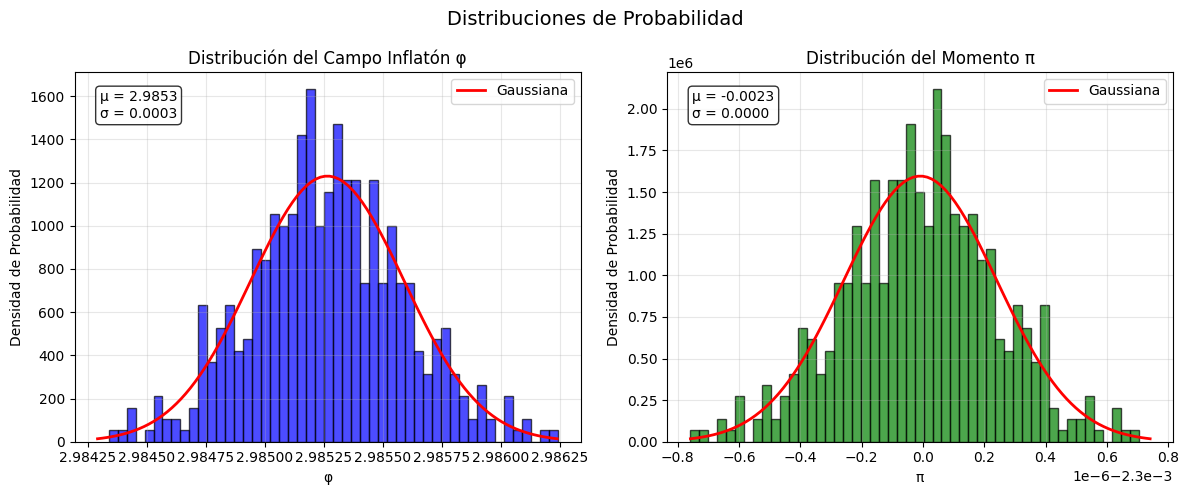

In [16]:
#Se produce una prueba sobre los ruidos cuanticos
points = 10
lenght = 10
realizations = 500
universe_grid = universe(points, lenght)
#Test de las ecuaciones de Evolución de Langevin
phi_0 = 3.0 * np.ones((points, points, points)) + np.random.normal(0, 0.1, (points, points, points))
pi_0 = np.zeros((points, points, points))

phi_evolution, pi_evolution = langevin_evol(phi_0, pi_0, universe_grid, tau_array, sigma, mass)

phi_finals, pi_finals, full_evolutions, time_something = universe_realizations(
    realizations, 3.0, 0.0, universe_grid, tau_array, sigma, 3, 50)

video = array_to_volume_video(data=phi_evolution, output_filename="phievo.gif", fps=10, cmap='seismic', step=2)

basic_stats = inflaton_pdf(phi_finals, pi_finals)


Apartir de aca se utiliza la implementación de la solución de Fockker Plank

In [17]:
#Se construye una función que se encarga de computar la matriz de difusión D (que a su vez dentro de si calcula Xi la mtriz de ruido cuantico), con anterioridad para que no se resuelvan en simultaneo al resolver fockker Plank
#De esta manera se utiliza una función Cache que ayuda a aminorar el tiempo de ejecución en general
def diffusion_matrix(mesh, tau, sigma, delta_tau, realizations):

    n_x, n_y, n_z = mesh['X'].shape
    
    xi_phi_phi = np.zeros((n_x, n_y, n_z))
    xi_phi_pi = np.zeros((n_x, n_y, n_z))
    xi_pi_phi = np.zeros((n_x, n_y, n_z))
    xi_pi_pi = np.zeros((n_x, n_y, n_z))
    
    #Se promedia para obtener los valores de expectación
    for realization in range(realizations):
        seed = realization * 1000
        np.random.seed(seed)

        xi_phi = calc_noise(mesh, tau, sigma, "phi")
        xi_pi = calc_noise(mesh, tau, sigma, "pi")

        xi_phi_phi += xi_phi * xi_phi 
        xi_phi_pi += xi_phi * xi_pi    
        xi_pi_phi += xi_pi * xi_phi    
        xi_pi_pi += xi_pi * xi_pi      
    
    #Se promedia por la realizaciones
    xi_phi_phi /= realizations
    xi_phi_pi /= realizations
    xi_pi_phi /= realizations
    xi_pi_pi /= realizations
    
    #Matrices de Pauli para obtener D
    I = np.eye(2)                     
    J_x = np.array([[0, 1], [1, 0]]) 
    J_z = np.array([[1, 0], [0, -1]]) 
    
    D_matrix = np.zeros((n_x, n_y, n_z, 2, 2))
    
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                Xi_pp = xi_phi_phi[i, j, k]    
                Xi_pphi = xi_phi_pi[i, j, k]     
                Xi_phip = xi_pi_phi[i, j, k]   
                Xi_pipi = xi_pi_pi[i, j, k]    
                
                #Se aplica la formula de venin
                D_point = (0.5 * (Xi_pp + Xi_pipi)) * I + (0.5 * (Xi_pphi + Xi_phip)) * J_x + (0.5 * (Xi_pp - Xi_pipi)) * J_z
                
                #Se normaliza por delta tau, esto debido a que es un proceso Markoviano
                D_matrix[i, j, k] = D_point / delta_tau
                
    return D_matrix

In [18]:
def diffusion_cache(mesh, tau_array, sigma, delta_tau, realizations):
    D_cache = {}
    
    for tau in tqdm(tau_array):
        D_matrix = diffusion_matrix(mesh, tau, sigma, delta_tau, realizations)
        D_cache[tau] = D_matrix
    
    return D_cache

In [19]:
def A_matrix(tau, H_inf, mass, N=1):
    a = -1 / (H_inf * tau)
    a3 = a**3

    A_matrix = np.array([
        [0, N / a3],
        [-mass**2 * N * a3, 0]
    ])
    
    return A_matrix

In [20]:
#Se desarolla la función de avance basado en diferencias finitas para la obtención de La pdf de Fockker Plank Global
def fp_step_global(P_prev, phi_grid, pi_grid, A_matrix, D_matrix, delta_tau):

    n_phi, n_pi = P_prev.shape
    dphi = phi_grid[1] - phi_grid[0]
    dpi = pi_grid[1] - pi_grid[0]
    
    P_next = np.zeros((n_phi, n_pi))
    
    # Coeficientes para términos de deriva
    A_phi = A_matrix[0, 1]
    A_pi = A_matrix[1, 0]
    
    # Coeficientes de difusión
    D_phi_phi = D_matrix[0, 0]
    D_phi_pi = D_matrix[0, 1]  
    D_pi_pi = D_matrix[1, 1]
    
    for i in range(1, n_phi-1):
        for j in range(1, n_pi-1):
            drift_phi = -A_phi * pi_grid[j] * (P_prev[i+1, j] - P_prev[i-1, j]) / (2 * dphi)
            drift_pi = -A_pi * phi_grid[i] * (P_prev[i, j+1] - P_prev[i, j-1]) / (2 * dpi)
            
            diff_phi = D_phi_phi * (P_prev[i+1, j] - 2*P_prev[i, j] + P_prev[i-1, j]) / (dphi**2)
            diff_pi = D_pi_pi * (P_prev[i, j+1] - 2*P_prev[i, j] + P_prev[i, j-1]) / (dpi**2)
            diff_mixed = D_phi_pi * (P_prev[i+1, j+1] - P_prev[i+1, j-1] - P_prev[i-1, j+1] + P_prev[i-1, j-1]) / (4 * dphi * dpi)
            
            P_next[i, j] = P_prev[i, j] + delta_tau * (drift_phi + drift_pi + 0.5 * (diff_phi + diff_pi + 2 * diff_mixed))
    
    P_next[0, :] = P_next[1, :]
    P_next[-1, :] = P_next[-2, :]
    P_next[:, 0] = P_next[:, 1]
    P_next[:, -1] = P_next[:, -2]
    
    # Normalizar
    P_next = P_next / (np.sum(P_next) * dphi * dpi)
    
    return P_next

In [21]:
def fokker_planck_global(initial_P, phi_grid, pi_grid, tau_array, H_inf, mass, D_global, delta_tau):
    n_tau = len(tau_array)
    n_phi, n_pi = initial_P.shape
    
    # Inicializar solución
    P_solution = np.zeros((n_tau, n_phi, n_pi))
    P_solution[0] = initial_P.copy()
    
    # Crear malla 2D para cálculos vectorizados
    PHI, PI = np.meshgrid(phi_grid, pi_grid, indexing='ij')
    dphi = phi_grid[1] - phi_grid[0]
    dpi = pi_grid[1] - pi_grid[0]
    
    for step in tqdm(range(1, n_tau)):
        tau_prev = tau_array[step-1]
        
        # Obtener matrices para este tiempo
        A_mat = A_matrix(tau_prev, H_inf, mass)
        D_mat = D_global[step-1]
        
        P_prev = P_solution[step-1]
        P_next = fp_step_global(P_prev, phi_grid, pi_grid, A_mat, D_mat, delta_tau)
        P_solution[step] = P_next
    
    return {
        'P_solution': P_solution,
        'phi_grid': phi_grid,
        'pi_grid': pi_grid,
        'tau_array': tau_array
    }

In [22]:
def get_global_diffusion(D_cache):    
    # Ordenar los tau para asegurar consistencia
    tau_values = sorted(D_cache.keys())
    
    D_global_list = []
    
    for tau in tau_values:
        D_matrix_spatial = D_cache[tau]  # Forma: (n_x, n_y, n_z, 2, 2)
        
        # Promediar sobre todas las dimensiones espaciales
        # axis=(0,1,2) significa promediar sobre x, y, z
        D_avg = np.mean(D_matrix_spatial, axis=(0, 1, 2))
        
        D_global_list.append(D_avg)
    
    # Convertir a array 3D: (n_tau, 2, 2)
    D_global_array = np.array(D_global_list)
    
    return D_global_array

In [23]:
#Se desarolla la función que visualiza la solución a Fockker Plank de manera global
import matplotlib.pyplot as plt
import numpy as np

def visualize_fp_global(fp_solution, time_indices=None, save_path=None, show_plot=True):
    P_solution = fp_solution['P_solution']
    phi_grid = fp_solution['phi_grid']
    pi_grid = fp_solution['pi_grid']
    tau_array = fp_solution['tau_array']
    
    if time_indices is None:
        time_indices = [0, len(tau_array)//4, len(tau_array)//2, 3*len(tau_array)//4, -1]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, time_idx in enumerate(time_indices):
        if idx >= len(axes):
            break
            
        P = P_solution[time_idx]
        tau = tau_array[time_idx]
        
        # Contour plot
        cont = axes[idx].contourf(phi_grid, pi_grid, P.T, levels=20, cmap='viridis')
        axes[idx].set_xlabel('φ')
        axes[idx].set_ylabel('π')
        axes[idx].set_title(f'PDF en τ = {tau:.2f}')
        plt.colorbar(cont, ax=axes[idx])
    
    # Evolución temporal de momentos
    ax_stats = axes[-1]
    phi_means = [np.sum(phi_grid * np.sum(P, axis=1)) * (phi_grid[1]-phi_grid[0]) for P in P_solution]
    phi_stds = [np.sqrt(np.sum((phi_grid - mu)**2 * np.sum(P, axis=1)) * (phi_grid[1]-phi_grid[0])) 
                for mu, P in zip(phi_means, P_solution)]
    
    ax_stats.plot(tau_array, phi_means, 'b-', label='⟨φ⟩')
    ax_stats.fill_between(tau_array, 
                         np.array(phi_means) - np.array(phi_stds),
                         np.array(phi_means) + np.array(phi_stds),
                         alpha=0.3, label='±σ')
    ax_stats.set_xlabel('τ')
    ax_stats.set_ylabel('φ')
    ax_stats.set_title('Evolución de momentos')
    ax_stats.legend()
    ax_stats.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar la imagen
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Gráfica guardada en: {save_path}")
    
    # Mostrar la gráfica en Jupyter
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return fig 

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:02<00:00, 66.36it/s]
C:\Users\Hewlett Packard\AppData\Local\Temp\ipykernel_16280\698123622.py:34: RuntimeWarning: invalid value encountered in sqrt
  phi_stds = [np.sqrt(np.sum((phi_grid - mu)**2 * np.sum(P, axis=1)) * (phi_grid[1]-phi_grid[0]))


Gráfica guardada en: FockkerPlank.png


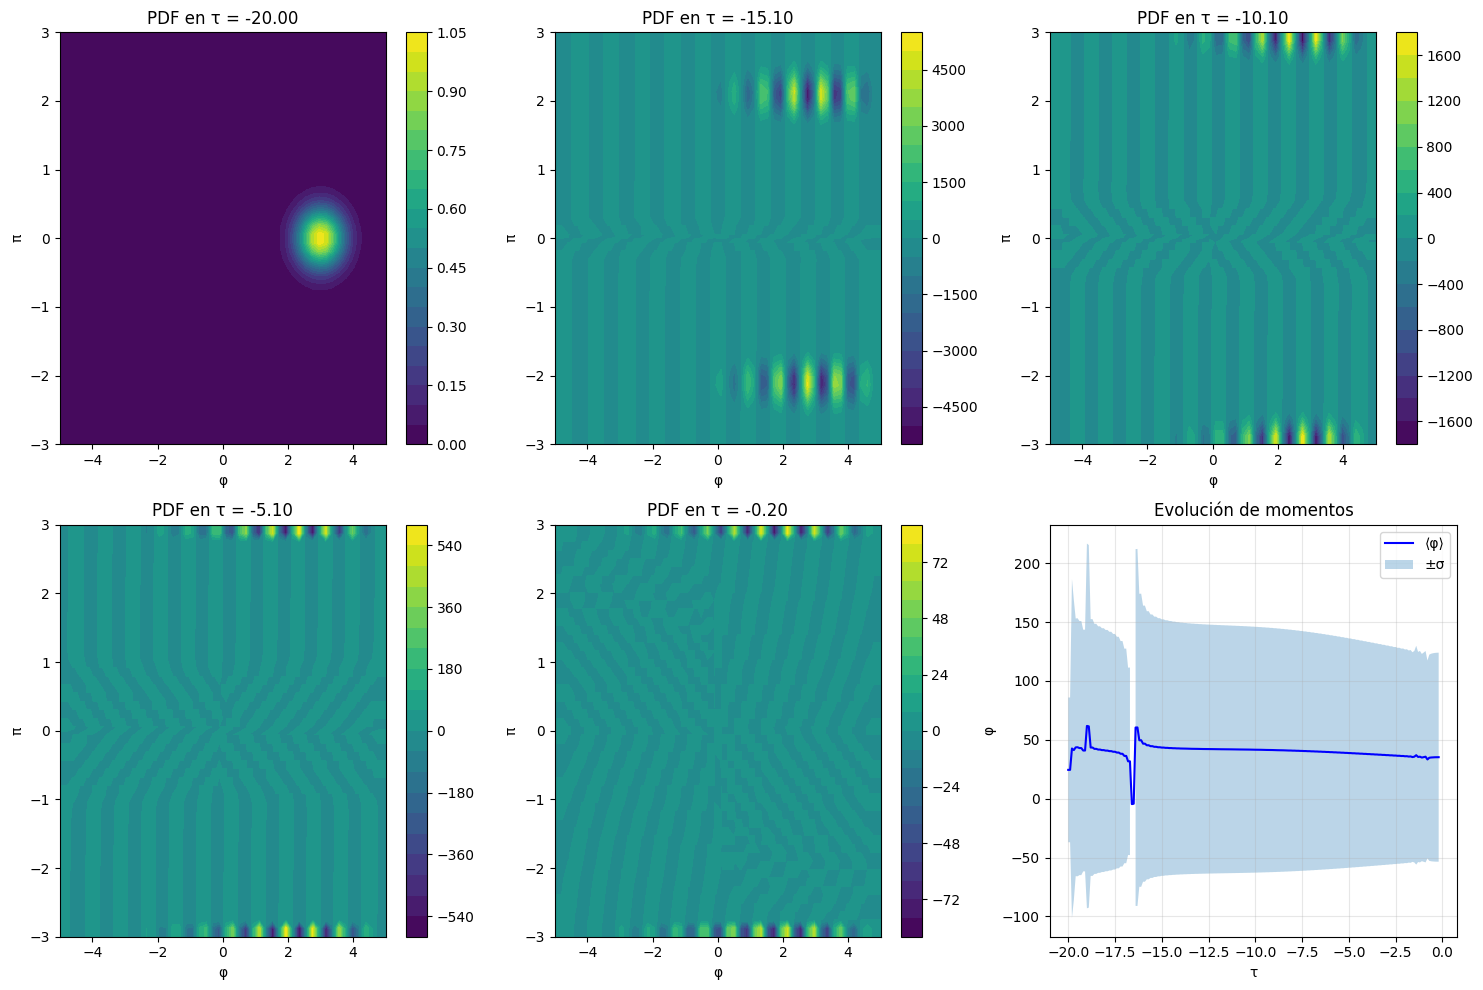

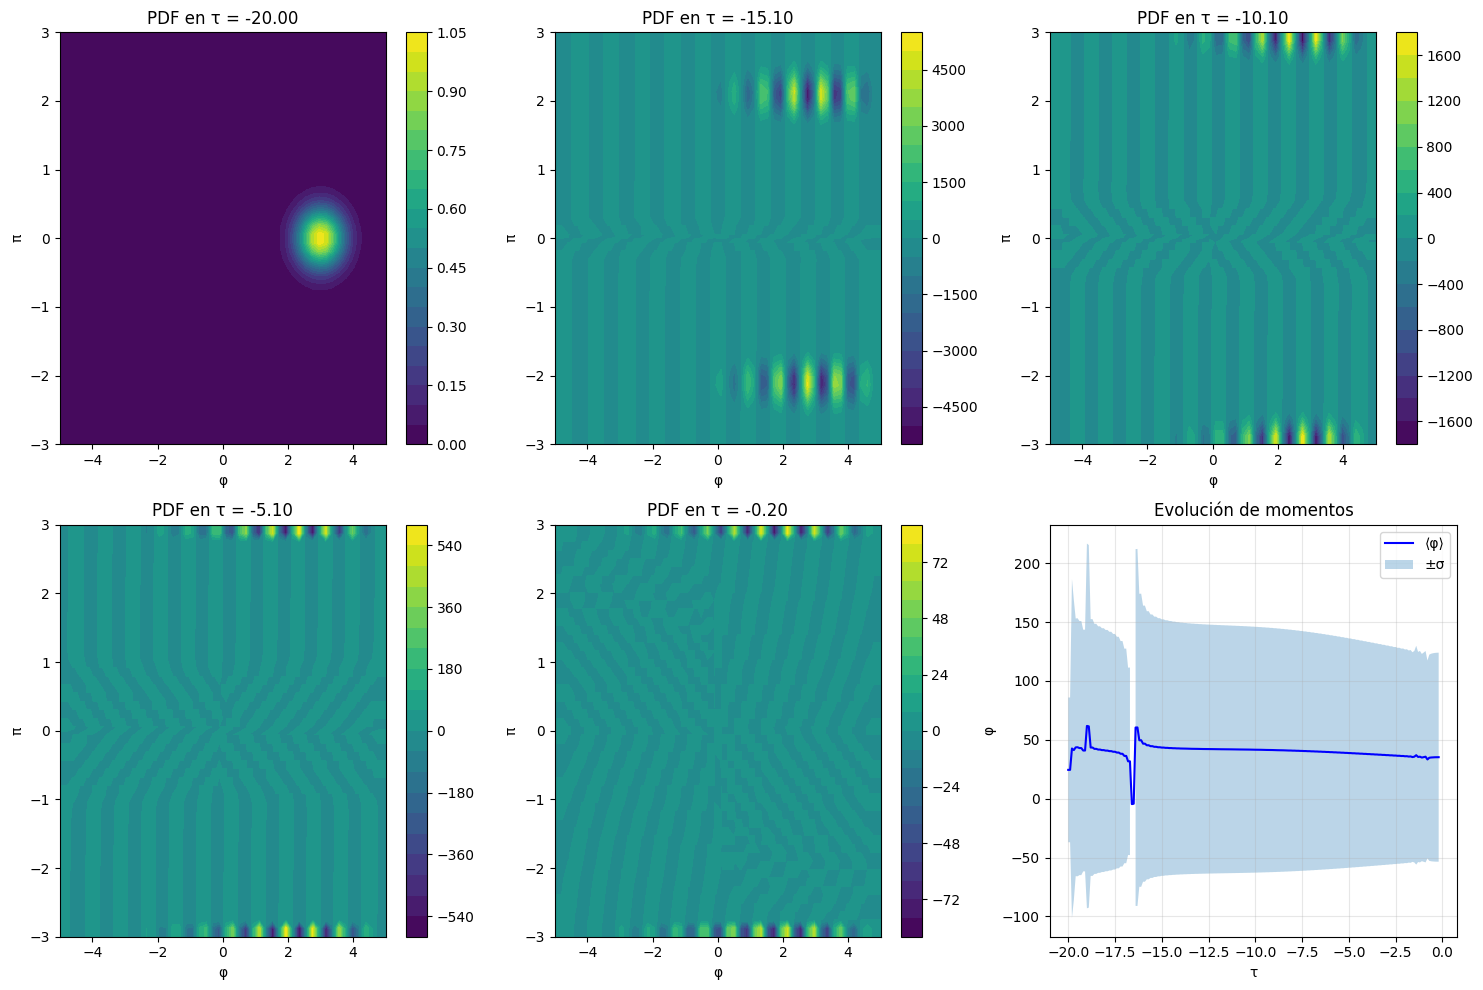

In [24]:
D_cache = diffusion_cache(universe_grid, tau_array, sigma, delta_tau, realizations)
D_global = get_global_diffusion(D_cache)

#Maya del espacio de fase
n_phi, n_pi = 50, 50
phi_grid = np.linspace(-5, 5, n_phi)  
pi_grid = np.linspace(-3, 3, n_pi)    

phi_0, pi_0 = 3.0, 0.0
sigma_phi_0, sigma_pi_0 = 0.5, 0.3

PHI, PI = np.meshgrid(phi_grid, pi_grid, indexing='ij')
initial_P = np.exp(-0.5*((PHI-phi_0)/sigma_phi_0)**2 - 0.5*((PI-pi_0)/sigma_pi_0)**2)
initial_P = initial_P / (np.sum(initial_P) * (phi_grid[1]-phi_grid[0]) * (pi_grid[1]-pi_grid[0]))

#Resolción de Fockker Plank
fp_solution = fokker_planck_global(initial_P, phi_grid, pi_grid, tau_array, H_inf, mass, D_global, delta_tau)

visualize_fp_global(fp_solution, save_path="FockkerPlank.png")


In [25]:
def compare_fp_langevin(fp_solution, phi_finals, pi_finals, tau_array):
    # Extraer PDF final de Fokker-Planck
    P_final_fp = fp_solution['P_solution'][-1]
    phi_grid = fp_solution['phi_grid']
    pi_grid = fp_solution['pi_grid']
    
    #Calcular momentos de Fokker-Planck
    dphi = phi_grid[1] - phi_grid[0]
    dpi = pi_grid[1] - pi_grid[0]
    
    #PDF marginal de φ en Fokker-Planck
    marginal_phi_fp = np.sum(P_final_fp, axis=1) * dpi
    marginal_pi_fp = np.sum(P_final_fp, axis=0) * dphi
    
    # Momentos de Fokker-Planck
    mean_phi_fp = np.sum(phi_grid * marginal_phi_fp) * dphi
    mean_pi_fp = np.sum(pi_grid * marginal_pi_fp) * dpi
    var_phi_fp = np.sum((phi_grid - mean_phi_fp)**2 * marginal_phi_fp) * dphi
    var_pi_fp = np.sum((pi_grid - mean_pi_fp)**2 * marginal_pi_fp) * dpi
    std_phi_fp = np.sqrt(var_phi_fp)
    std_pi_fp = np.sqrt(var_pi_fp)
    
    # Momentos de Langevin
    mean_phi_lang = np.mean(phi_finals)
    mean_pi_lang = np.mean(pi_finals)
    std_phi_lang = np.std(phi_finals)
    std_pi_lang = np.std(pi_finals)
    
    print("Comparación de Fockker-Plank contra Langevin")
    
    print(f"\n--- Momentos de φ ---")
    print(f"Media:  FP = {mean_phi_fp:.6f}, Langevin = {mean_phi_lang:.6f}")
    print(f"Diff:   {abs(mean_phi_fp - mean_phi_lang):.6f}")
    print(f"Desv:   FP = {std_phi_fp:.6f}, Langevin = {std_phi_lang:.6f}")
    print(f"Diff:   {abs(std_phi_fp - std_phi_lang):.6f}")
    
    print(f"\n--- Momentos de π ---")
    print(f"Media:  FP = {mean_pi_fp:.6f}, Langevin = {mean_pi_lang:.6f}")
    print(f"Diff:   {abs(mean_pi_fp - mean_pi_lang):.6f}")
    print(f"Desv:   FP = {std_pi_fp:.6f}, Langevin = {std_pi_lang:.6f}")
    print(f"Diff:   {abs(std_pi_fp - std_pi_lang):.6f}")
    
    # Errores relativos
    rel_error_phi_mean = abs(mean_phi_fp - mean_phi_lang) / abs(mean_phi_lang) * 100
    rel_error_phi_std = abs(std_phi_fp - std_phi_lang) / std_phi_lang * 100
    
    print(f"\n--- Errores relativos ---")
    print(f"Media φ: {rel_error_phi_mean:.2f}%")
    print(f"Desv φ:  {rel_error_phi_std:.2f}%")
    
    
    return {
        'fp_means': (mean_phi_fp, mean_pi_fp),
        'fp_stds': (std_phi_fp, std_pi_fp),
        'lang_means': (mean_phi_lang, mean_pi_lang),
        'lang_stds': (std_phi_lang, std_pi_lang),
        'relative_errors': (rel_error_phi_mean, rel_error_phi_std)
    }


comparison_stats = compare_fp_langevin(fp_solution, phi_finals, pi_finals, tau_array)

Comparación de Fockker-Plank contra Langevin

--- Momentos de φ ---
Media:  FP = 4.317496, Langevin = 2.985265
Diff:   1.332231
Desv:   FP = 2.601249, Langevin = 0.000324
Diff:   2.600925

--- Momentos de π ---
Media:  FP = 0.056517, Langevin = -0.002300
Diff:   0.058817
Desv:   FP = 2.937748, Langevin = 0.000000
Diff:   2.937748

--- Errores relativos ---
Media φ: 44.63%
Desv φ:  801842.05%
